In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pickle
import re
import string
from unicodedata import normalize
import pickle
from tqdm import tqdm
from collections import defaultdict, Counter

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

In [ ]:
import torchtext

In [ ]:
train, val, test = torchtext.datasets.IWSLT2016(root='.data', split=('train', 'valid', 'test'), language_pair=('fr', 'en'), valid_set='tst2013', test_set='tst2014')

2016-01.tgz: 188MB [00:05, 32.4MB/s]


In [ ]:
next(iter(test))

("Quand j'avais la vingtaine, j'ai vu mes tout premiers clients comme psychothérapeute.\n",
 'When I was in my 20s, I saw my very first psychotherapy client.\n')

In [ ]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [ ]:
device

'cuda'

In [ ]:
def load_doc(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def to_sentences(doc):
    return doc.strip().split('\n')

def clean_line(line):
    re_print = re.compile('[^%s]'% re.escape(string.printable))
    table = str.maketrans('', '', string.punctuation)
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    line = line.split()
    line = [word.lower() for word in line]
    line = [word.translate(table) for word in line]
    line = [re_print.sub('', w) for w in line]
    line = [w for w in line if w.isalpha()]
    return " ".join(word for word in line)

def load_pickle(filename):
    rfile = open(filename, 'rb')
    arr = pickle.load(rfile)
    return arr

def save_sentences(sents, filename):
    pickle.dump(sents, open(filename, 'wb'))
    print("Saved...")

In [ ]:
# engs = load_pickle('/content/english_parl.pkl')
# frs = load_pickle('/content/french_parl.pkl')

In [ ]:
def get_avglen(data):
    size = 0
    for line in data:
        size += len(line.split())
    return size / len(data)

In [ ]:
fr_data, eng_data = [], []
for pair in enumerate(train):
  src, target = pair[1]
  # print(pair)
  fr_data.append(clean_line(src))
  eng_data.append(clean_line(target))

In [ ]:
fr_val, eng_val = [], []
for pair in enumerate(val):
  src, target = pair[1]
  fr_val.append(clean_line(src))
  eng_val.append(clean_line(target))

In [ ]:
len(fr_val), len(fr_data)

(1026, 220400)

In [ ]:
def tokenize(data, vocab_size):
    
    ctr = Counter()
    m = len(data)
    for i in tqdm(range(m)):
        sent = data[i]
        line = sent.split()
        ctr.update(line)
    tokens = [k for k,c in ctr.items()][:vocab_size]
    # print("Len of ctr", len(ctr))
    word2idx, idx2word = {}, {}
    word2idx['<start>'], idx2word[0] = 0, '<start>'
    word2idx['<end>'], idx2word[1] = 1, '<end>'
    word2idx['<pad>'], idx2word[2] = 2, '<pad>'
    word2idx['<unk>'], idx2word[3] = 3, '<unk>'
    cur = 4
    for word in tokens:
        word2idx[word] = cur
        idx2word[cur] = word
        cur += 1
    return word2idx, idx2word, ctr

In [ ]:
# tokenize(fr_data, 10000)

In [ ]:
fr_word2idx, fr_idx2word, fctr = tokenize(fr_data, 15000)

100%|██████████| 220400/220400 [00:01<00:00, 200944.40it/s]


In [ ]:
eng_word2idx, eng_idx2word, ectr = tokenize(eng_data, 15000)

100%|██████████| 220400/220400 [00:01<00:00, 209665.73it/s]


In [ ]:
def nums(sentence, word2idx, idx2word):
    line = sentence.split()
    res = [0]
    for word in line:
        if word in word2idx.keys():
            res.append(word2idx[word])
            continue
        res.append(word2idx['<unk>'])
    res.append(1)
    return res

In [ ]:
line = nums(eng_data[0], eng_word2idx,  eng_idx2word)
print([eng_idx2word[idx] for idx in line])
eng_data[0]

['<start>', 'david', 'gallo', 'this', 'is', 'bill', 'lange', 'im', 'dave', 'gallo', '<end>']


'david gallo this is bill lange im dave gallo'

In [ ]:
def maxlen(data):
    nax = 0
    for line in data:
        nax = max(nax, len(line.split()))
    return nax

In [ ]:
lens = []
for line in eng_data:
  lens.append(len(line.split()))

In [ ]:
cnt = 0
for size in lens:
  if size <= 10:
    cnt += 1
cnt

77009

In [ ]:
train_data = []
train_target = []
for i, sent in enumerate(fr_data):
  if len(sent.split()) <= 10 and len(eng_data[i].split()) <= 10:
    # l = sent.split()
    # l.reverse()
    # sent = " ".join(word for word in l)
    train_data.append(sent)
    train_target.append(eng_data[i])

In [ ]:
train_data[0]

'david gallo voici bill lange je suis dave gallo'

In [ ]:
val_data = []
val_target = []
for i, sent in enumerate(fr_val):
  if len(sent.split()) <= 10 and len(eng_val[i].split()) <= 10:
    # l = sent.split()
    # l.reverse()
    # sent = " ".join(word for word in l)
    val_data.append(sent)
    val_target.append(eng_val[i])
len(val_data), len(val_target)

(294, 294)

In [ ]:
def nums(sentence, word2idx, idx2word):
    line = sentence.split()
    res = [0]
    for word in line:
        if word in word2idx.keys():
            res.append(word2idx[word])
            continue
        res.append(word2idx['<unk>'])
    res.append(1)
    return res

In [ ]:
def pad_seqr(pad, data, padding):
  size = len(data)
  padded = np.zeros((size, pad+2))
  for i in range(size):
    for j, k in enumerate(data[i]):
      padded[i][pad+1-j] = k
    for j in range(len(data[i]), pad+2):
      padded[i][pad+1-j] = padding
  padded = padded.astype('int32')
  return padded

def pad_seq(pad, data, padding):
  size = len(data)
  padded = np.zeros((size, pad+2))
  for i in range(size):
    for j, k in enumerate(data[i]):
      padded[i][j] = k
    for j in range(len(data[i]), pad+2):
      padded[i][j] = padding
  padded = padded.astype('int32')
  return padded

In [ ]:
tokenized_train = [nums(sent, fr_word2idx, fr_idx2word) for sent in train_data]
tokenized_target = [nums(sent, eng_word2idx, eng_idx2word) for sent in train_target]

In [ ]:
nax = 0
for line in tokenized_train:
  nax = max(len(line), nax)
nax

12

In [ ]:
# pad_eng = pad_seq(40, tokenized_eng, 2)
pad_train = pad_seq(10, tokenized_train, 2)
pad_target = pad_seq(10, tokenized_target, 2)

In [ ]:
pad_train.shape

(66148, 12)

In [ ]:
idxs = np.random.choice(pad_train.shape[0], 50000, replace=False)

In [ ]:
pad_train = pad_train[idxs]
pad_target = pad_target[idxs]

In [ ]:
print(" ".join(word for word in [fr_idx2word[idx] for idx in pad_train[2]]))
print(" ".join(word for word in [eng_idx2word[idx] for idx in pad_target[2]]))

<start> la profondeur moyenne est environ km <end> <pad> <pad> <pad> <pad>
<start> the average depth is about two miles <end> <pad> <pad> <pad>


In [ ]:
class TrainDataset(Dataset):
  def __init__(self, train_data, train_target):
    self.train = train_data
    self.target = train_target
  def __len__(self):
    return len(self.train)
  def __getitem__(self, idx):
    return self.train[idx], self.target[idx]

In [ ]:
BATCH_SIZE = 32

In [ ]:
data = TrainDataset(pad_train, pad_target)
train_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# train_loader = train_loader.to(device)

In [ ]:
train, target = next(iter(train_loader))

In [ ]:
target.dtype

torch.int32

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, enc_units, dropout=0):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        # self.gru = nn.GRU(embedding_dim, enc_units, batch_first=True, dropout=drop)
        self.gru = nn.GRU(embedding_dim, enc_units, batch_first=True)
    
    def forward(self, x):
        x = self.embedding(x)
        out, h = self.gru(x)
        return out, h
    
    def initHidden(self, batch_size):
      hidden = torch.zeros(batch_size, self.enc_units, device=device)
      return hidden

In [ ]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, enc_units, dropout=0):
        super(EncoderLSTM, self).__init__()
        self.enc_units = enc_units
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, enc_units, batch_first=True)
    
    def forward(self, x):
        x = self.embedding(x)
        out, (h, c) = self.lstm(x)
        return out, h, c
    
    def initHidden(self, batch_size):
      hidden = torch.zeros(batch_size, self.enc_units, device=device)
      return hidden

In [ ]:
class DecoderLSTMv2(nn.Module):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(DecoderLSTMv2, self).__init__()
    self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
    self.Wc = nn.Linear(2*dec_units, dec_units)
    self.Ws = nn.Linear(dec_units, output_vocab_size)
    self.lstm = nn.LSTM(embedding_dim+12, dec_units, batch_first=True)
    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim=1)
    self.dec_units = dec_units
    self.embedding_dim = embedding_dim

  def forward(self, x, values, hidden, context, attention):
    x = self.embedding(x)
    # print("X Shape:", x.shape, "Attention Shape:", attention.shape)
    x = torch.cat((x, attention), 2)
    # print("X shape:", x.shape, "HiddenShape:", hidden.shape)
    # Shape of X is (Batch_Size, 1, Embedding_dim)
    o, (ht, c0) = self.lstm(x, (hidden,context))
    # print("O Shape:",o.shape, "ht shape:", ht.shape)
    # Shape of o is (Batch_Size, 1, Hidden_Units); Shape of h is (Batch_Size, 1, Hidden_units)
    # Shape of Values is (Batch_Size, Seq_Len, Hidden_Units)
    ht = ht.squeeze(dim=0)
    ht = ht.unsqueeze(dim=-1)
    # print("Values Shape:", values.shape, "ht shape:", ht.shape)
    et = torch.bmm(values, ht)
    # Shape of et is (Batch Size, Seq_Len, 1)
    # print("Et Shape:", et.shape)
    at = self.softmax(et)
    # print("At Shape:",at.shape)
    # Shape of at is (Batch Size, Seq_Len, 1)
    at = at.squeeze(dim=-1)
    # print("At Shape:",at.shape)
    # Shape of at is (Batch Size, Seq_Len)
    at = at.unsqueeze(dim=1)
    # print("At Shape:",at.shape)
    # Shape of at is (Batch Size, 1, Seq_Len)
    ct = torch.bmm(at, values)
    # print("ct Shape:",ct.shape)
    # Shape of ct is (Batch Size, 1, d)
    ht = ht.squeeze(dim=-1)
    # print("Ht Shape:",ht.shape)
    ht = ht.unsqueeze(dim=1)
    # print("Ht Shape:",ht.shape)
    att_vec = torch.cat((ht, ct), dim=-1)
    # print("att_vec Shape:",att_vec.shape)
    # Shape of hp is (Batch Size, 1, 2*d)
    hp = self.Wc(att_vec)
    # print("Hp Shape:",hp.shape)
    # Shape of hp is (Batch Size, 1, d)
    hp = self.tanh(hp)

    preds = self.Ws(hp)
    # print("preds Shape:",preds.shape)
    # Shape of Preds is (Batch Size, 1, output_vocab_size)
    return preds, ct, ht, at, c0
  def initHidden(self, batch_size):
    hidden = torch.zeros(batch_size, self.dec_units, device=device)
    return hidden

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
    self.Wc = nn.Linear(2*dec_units, dec_units)
    self.Ws = nn.Linear(dec_units, output_vocab_size)
    self.gru = nn.GRU(embedding_dim, dec_units, batch_first=True)
    self.tanh = nn.Tanh()
    self.softmax = nn.Softmax(dim=1)
    self.dec_units = dec_units
    self.embedding_dim = embedding_dim

  def forward(self, x, values, hidden):
    x = self.embedding(x)
    # print("X shape:", x.shape, "HiddenShape:", hidden.shape)
    # Shape of X is (Batch_Size, 1, Embedding_dim)
    o, ht = self.gru(x, hidden)
    # print("O Shape:",o.shape, "ht shape:", ht.shape)
    # Shape of o is (Batch_Size, 1, Hidden_Units); Shape of h is (Batch_Size, 1, Hidden_units)
    # Shape of Values is (Batch_Size, Seq_Len, Hidden_Units)
    ht = ht.squeeze(dim=0)
    ht = ht.unsqueeze(dim=-1)
    # print("Values Shape:", values.shape, "ht shape:", ht.shape)
    et = torch.bmm(values, ht)
    # Shape of et is (Batch Size, Seq_Len, 1)
    # print("Et Shape:", et.shape)
    at = self.softmax(et)
    # print("At Shape:",at.shape)
    # Shape of at is (Batch Size, Seq_Len, 1)
    at = at.squeeze(dim=-1)
    # print("At Shape:",at.shape)
    # Shape of at is (Batch Size, Seq_Len)
    at = at.unsqueeze(dim=1)
    # print("At Shape:",at.shape)
    # Shape of at is (Batch Size, 1, Seq_Len)
    ct = torch.bmm(at, values)
    # print("ct Shape:",ct.shape)
    # Shape of ct is (Batch Size, 1, d)
    ht = ht.squeeze(dim=-1)
    # print("Ht Shape:",ht.shape)
    ht = ht.unsqueeze(dim=1)
    # print("Ht Shape:",ht.shape)
    att_vec = torch.cat((ht, ct), dim=-1)
    # print("att_vec Shape:",att_vec.shape)
    # Shape of hp is (Batch Size, 1, 2*d)
    hp = self.Wc(att_vec)
    # print("Hp Shape:",hp.shape)
    # Shape of hp is (Batch Size, 1, d)
    hp = self.tanh(hp)

    preds = self.Ws(hp)
    # print("preds Shape:",preds.shape)
    # Shape of Preds is (Batch Size, 1, output_vocab_size)
    return preds, ct, ht, at
  def initHidden(self, batch_size):
    hidden = torch.zeros(batch_size, self.dec_units, device=device)
    return hidden

In [ ]:
encoder = Encoder(len(fr_word2idx.keys()), 512, 1024, dropout=0.4).to(device)
decoder = Decoder(len(eng_word2idx.keys()), 512, 1024).to(device)

In [ ]:
dec_units = 1024
encoderv2 = EncoderLSTM(len(fr_word2idx.keys()), 512, dec_units, dropout=0.2).to(device)
decoderv2 = DecoderLSTMv2(len(eng_word2idx.keys()), 512, dec_units).to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
lr = 0.0005
encoderv2_optim = optim.Adam(encoderv2.parameters(), lr = lr)
decoderv2_optim = optim.Adam(decoderv2.parameters(), lr = lr)

In [ ]:
len(fr_word2idx.keys())

15004

In [ ]:
# criterion = nn.CrossEntropyLoss(reduction='none')
# lr = 0.0005
# encoder_optim = optim.Adam(encoder_rev.parameters(), lr = lr)
# decoder_optim = optim.Adam(decoder_rev.parameters(), lr = lr)

In [ ]:
def train_seq2seq_gru(encoder, decoder, encoder_optim, decoder_optim, traindata, EPOCHS=10):
  step_losses, epoch_losses = [], []
  length = 12
  size = 66148
  for epoch in range(1, EPOCHS+1):
    total_loss = 0
    step_loss = 0
    for i, data in enumerate(traindata):
      train, target = data
      train = train.to(device)
      target = target.to(device)
      train, target = train.type(torch.long), target.type(torch.long)
      encoder_optim.zero_grad()
      decoder_optim.zero_grad()
      loss = 0
      enc_h = encoder.initHidden(BATCH_SIZE)
      enc_out, h = encoder(train)
      dec_h = h
      dec_inp = train[:,0]
      # print("Enc Out Shape:", enc_out.shape)
      # print("Dec Inp Shape:", dec_inp.shape)
      
      for j in range(length-1):
        dec_inp = dec_inp.unsqueeze(dim=1)
        # print("Dec_INp Shape:", dec_inp.shape)
        dec_out, ct, dec_h, _ = decoder(dec_inp, enc_out, dec_h)
        dec_out = dec_out.squeeze(dim=1)
        loss_v = criterion(dec_out, target[:,j+1])
        # print("Loss_V:", loss_v)
        # print("Loss_V.mean:", loss_v.mean())
        # exit()
        mult = (target[:,j+1] != 2)*1
        loss_v = (loss_v*mult)
        loss += loss_v.mean()
        total_loss += loss_v.mean().item()
        dec_inp = target[:,j+1]
        dec_h = dec_h.squeeze(dim=1)
        dec_h = dec_h.unsqueeze(dim=0)
        step_loss += loss_v.mean().item()
      if (i+1) % 200 == 0:
        print("Epoch : {} Step Loss :{:.4f} I:{}".format(epoch, step_loss / (BATCH_SIZE*200), i+1))
        step_losses.append(step_loss / (BATCH_SIZE*200))
        step_loss = 0
      loss.backward()
      encoder_optim.step()
      decoder_optim.step()
    epoch_losses.append(total_loss / (size))
    print("Epoch : {} Loss : {:.4f}".format(epoch,  total_loss / (size)))
  return step_losses, epoch_losses

In [ ]:
def train_seq2seq(encoder, decoder, encoder_optim, decoder_optim, traindata, EPOCHS=10):
  step_losses, epoch_losses = [], []
  length = 12
  size = 66148
  for epoch in range(1, EPOCHS+1):
    total_loss = 0
    step_loss = 0
    for i, data in enumerate(traindata):
      train, target = data
      train = train.to(device)
      target = target.to(device)
      train, target = train.type(torch.long), target.type(torch.long)
      encoder_optim.zero_grad()
      decoder_optim.zero_grad()
      loss = 0
      enc_h = encoder.initHidden(BATCH_SIZE)
      enc_out, h, c0 = encoder(train)
      dec_h = h
      dec_c = c0
      dec_inp = train[:,0]
      attention = torch.zeros((BATCH_SIZE, 1, 12), device=device, dtype=torch.long)
      # attention.dtype = torch.long
      # print("Enc Out Shape:", enc_out.shape)
      # print("Dec Inp Shape:", dec_inp.shape)
      
      for j in range(length-1):
        dec_inp = dec_inp.unsqueeze(dim=1)
        # print("Dec_INp Shape:", dec_inp.shape)
        # print("Dec C BeforeShape:",dec_c.shape, "Dec H BeforeShape:", dec_h.shape)
        dec_out, ct, dec_h, attention, dec_c = decoder(dec_inp, enc_out, dec_h, dec_c, attention)
        # print("Dec C Shape:",dec_c.shape, "Dec H Shape:", dec_h.shape)
        # print("Attention Shape:",attention.shape)
        # break
        dec_out = dec_out.squeeze(dim=1)
        loss_v = criterion(dec_out, target[:,j+1])
        # print("Loss_V:", loss_v)
        # print("Loss_V.mean:", loss_v.mean())
        # exit()
        mult = (target[:,j+1] != 2)*1
        loss_v = (loss_v*mult)
        loss += loss_v.mean()
        total_loss += loss_v.mean().item()
        dec_inp = target[:,j+1]
        dec_h = dec_h.squeeze(dim=1)
        dec_h = dec_h.unsqueeze(dim=0)
        # dec_c = dec_c.squeeze(dim=0)
        # dec_c = dec_c.unsqueeze(dim=1)
        step_loss += loss_v.mean().item()
      if (i+1) % 1000 == 0:
        print("Epoch : {} Step Loss :{:.4f} I:{}".format(epoch, step_loss / (BATCH_SIZE*1000), i+1))
        step_losses.append(step_loss / (BATCH_SIZE*1000))
        step_loss = 0
      # print("Loss",loss)
      loss.backward()
      encoder_optim.step()
      decoder_optim.step()
    epoch_losses.append(total_loss / (size))
    print("Epoch : {} Loss : {:.4f}".format(epoch,  total_loss / (size)))
  return step_losses, epoch_losses

In [ ]:
step_loss, epoch_loss = train_seq2seq_lstm(encoderv2, decoderv2, encoderv2_optim, decoderv2_optim, train_loader, 20)

Epoch : 1 Step Loss :1.0860 I:1000
Epoch : 1 Step Loss :0.8085 I:2000
Epoch : 1 Loss : 0.9407
Epoch : 2 Step Loss :0.6279 I:1000
Epoch : 2 Step Loss :0.6098 I:2000
Epoch : 2 Loss : 0.6179
Epoch : 3 Step Loss :0.4479 I:1000
Epoch : 3 Step Loss :0.4729 I:2000
Epoch : 3 Loss : 0.4608
Epoch : 4 Step Loss :0.3288 I:1000
Epoch : 4 Step Loss :0.3576 I:2000
Epoch : 4 Loss : 0.3439
Epoch : 5 Step Loss :0.2381 I:1000
Epoch : 5 Step Loss :0.2673 I:2000
Epoch : 5 Loss : 0.2535
Epoch : 6 Step Loss :0.1747 I:1000
Epoch : 6 Step Loss :0.2011 I:2000
Epoch : 6 Loss : 0.1886
Epoch : 7 Step Loss :0.1343 I:1000
Epoch : 7 Step Loss :0.1579 I:2000
Epoch : 7 Loss : 0.1469
Epoch : 8 Step Loss :0.1084 I:1000
Epoch : 8 Step Loss :0.1293 I:2000
Epoch : 8 Loss : 0.1194
Epoch : 9 Step Loss :0.0917 I:1000
Epoch : 9 Step Loss :0.1093 I:2000
Epoch : 9 Loss : 0.1010
Epoch : 10 Step Loss :0.0773 I:1000
Epoch : 10 Step Loss :0.0958 I:2000
Epoch : 10 Loss : 0.0870
Epoch : 11 Step Loss :0.0670 I:1000
Epoch : 11 Step Loss 

In [ ]:
# step_loss, epoch_loss = train_seq2seq(encoder, decoder, encoder_optim, decoder_optim, train_loader, 20)

In [ ]:
# step_loss, epoch_loss = train_seq2seq_lstm(encoderv2, decoderv2, encoderv2_optim, decoderv2_optim, train_loader, 20)

In [ ]:
# step_loss, epoch_loss = train_seq2seq(encoder_rev, decoder_rev, encoder_optim, decoder_optim, train_loader, 15)

In [ ]:
# step_loss, epoch_loss = train_seq2seq(encoder, decoder, encoder_optim, decoder_optim, train_loader, 14)

In [ ]:
# step_loss, epoch_loss = train_seq2seq(encoder, decoder, encoder_optim, decoder_optim, train_loader, 10)

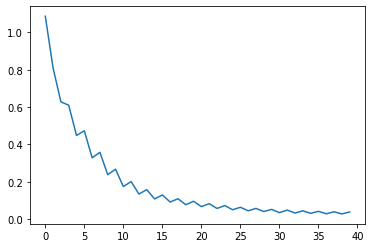

In [ ]:
plt.plot(step_loss)

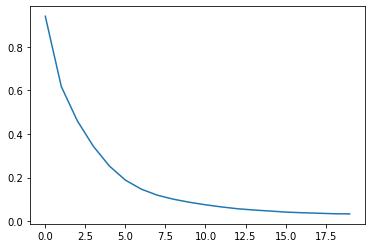

In [ ]:
plt.plot(epoch_loss)

In [ ]:
def predictv2(encoder, decoder, sent):
  sent = sent.unsqueeze(dim=0)
  sent = torch.tensor(sent).to(device)
  enc_h = encoder.initHidden(BATCH_SIZE)
  enc_out, h, dec_c = encoder(sent)
  enc_out = enc_out.to(device)
  h = h.to(device)
  dec_h = h
  dec_inp = torch.tensor([[0]]).to(device)
  arr = [0]
  size = 0
  attentions = []
  attn = torch.zeros((1, 1, sent.shape[1]), device=device, dtype=torch.long)
  # print("Enc out shape:", enc_out.shape)
  possible = [[1, 0, dec_inp, dec_h, attn, dec_c] for _ in range(beam_size)]
  while size < 100 and dec_inp.item() != 1:
    # print("Dec_inp",dec_inp.shape, attn.shape)
    dec_out, ct, dec_h, attn, dec_c = decoder(dec_inp, enc_out, dec_h, dec_c, attn)
    # print("attn",attn.shape)
    val = dec_out.argmax().item()
    # print("Val",val)
    attentions.append(attn.cpu().numpy())
    arr.append(val)
    dec_inp = torch.tensor([[val]], device=device)
    dec_h = dec_h.squeeze(dim=1)
    dec_h = dec_h.unsqueeze(dim=0)
    size += 1
  return arr, attentions

In [ ]:
def predictv2(encoder, decoder, sent, beam_size):
  sent = sent.unsqueeze(dim=0)
  sent = torch.tensor(sent).to(device)
  enc_h = encoder.initHidden(BATCH_SIZE)
  enc_out, h, dec_c = encoder(sent)
  enc_out = enc_out.to(device)
  h = h.to(device)
  dec_h = h
  dec_inp = torch.tensor([[0]]).to(device)
  arr = [0]
  size = 0
  attentions = []
  attn = torch.zeros((1, 1, sent.shape[1]), device=device, dtype=torch.long)
  # print("Enc out shape:", enc_out.shape)
  possible = [[1, 0, dec_inp, dec_h, attn, dec_c] for _ in range(beam_size)]
  results = []
  while size < 100 and dec_inp.item() != 1:
    # print("Dec_inp",dec_inp.shape, attn.shape)
    dec_out, ct, dec_h, attn, dec_c = decoder(dec_inp, enc_out, dec_h, dec_c, attn)
    # print("attn",attn.shape)
    val = dec_out.argmax().item()
    # print("Val",val)
    attentions.append(attn.cpu().numpy())
    arr.append(val)
    dec_inp = torch.tensor([[val]], device=device)
    dec_h = dec_h.squeeze(dim=1)
    dec_h = dec_h.unsqueeze(dim=0)
    size += 1
  return arr, attentions

In [ ]:
def predict(encoder, decoder, sent):
  sent = sent.unsqueeze(dim=0)
  sent = torch.tensor(sent).to(device)
  enc_h = encoder.initHidden(BATCH_SIZE)
  enc_out, h = encoder(sent)
  enc_out = enc_out.to(device)
  h = h.to(device)
  dec_h = h
  dec_inp = torch.tensor([[0]]).to(device)
  arr = [0]
  size = 0
  attentions = []
  
  while size < 100 and dec_inp.item() != 1:
    dec_out, ct, dec_h, attn = decoder(dec_inp, enc_out, dec_h)
    val = dec_out.argmax().item()
    # print("Val",val)
    attentions.append(attn.cpu().numpy())
    arr.append(val)
    dec_inp = torch.tensor([[val]], device=device)
    dec_h = dec_h.squeeze(dim=1)
    dec_h = dec_h.unsqueeze(dim=0)
    size += 1
  return arr, attentions

In [ ]:
def tokenize_sent(sent):
  sent = clean_line(sent)
  tokenized = nums(sent, fr_word2idx, fr_idx2word)
  return np.array(tokenized)

In [ ]:
idxs[0]

59359

In [ ]:
encoderv2 = encoderv2.eval()

In [ ]:
def pad_seq(pad, data, padding):
  size = len(data)
  padded = np.zeros((size, pad+2))
  for i in range(size):
    for j, k in enumerate(data[i]):
      padded[i][j] = k
    for j in range(len(data[i]), pad+2):
      padded[i][j] = padding
  padded = padded.astype('int32')
  return padded

In [ ]:
test = val_data
test_target = val_target
avg_bleu = 0
for i, sent in enumerate(test):
  sent = tokenize_sent(sent)
  sent = pad_seq(10, [sent], 2)
  # print(sent)
  sent = torch.tensor(sent[0], device=device)
  # print("sent:",sent.shape)
  inp = " ".join(word for word in [fr_idx2word[token] for token in sent.cpu().numpy()])
  with torch.no_grad():
    res, atts = predictv2(encoderv2, decoderv2, sent)
    # print(res)
    out = " ".join(word for word in [eng_idx2word[token] for token in res])
    # print(out.split())
    avg_bleu += sentence_bleu([inp.split()],out.split())
    if i % 50 == 0:
      print("Target:")
      print(test_target[i])
      print("Output:")
      print(out)
      print("--------------------------------------------------------------------------")
    # print([eng_idx2word[token] for token in res])
print("Score :", avg_bleu / len(test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Target:
and i was distraught
Output:
<start> and i was really thrilled <end>
--------------------------------------------------------------------------
Target:
these are lines of information
Output:
<start> its about <unk> information <end>
--------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Target:
we are the soil
Output:
<start> we have <end>
--------------------------------------------------------------------------
Target:
that was i dont know what happened there
Output:
<start> i dont know what happened there was this <unk> <end>
--------------------------------------------------------------------------
Target:
i want to challenge that do you know why
Output:
<start> i want to know that why <end>
--------------------------------------------------------------------------
Target:
theyre highspeed take about seconds at most
Output:
<start> theyre very quick they take about seconds to live <end>
--------------------------------------------------------------------------
Score : 0.41204250345645244


In [ ]:
reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
sentence_bleu(reference,candidate)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7071067811865475

In [ ]:
for i, sent in enumerate([train_data[idxs[10]]]):
  sent = tokenize_sent(sent)
  sent = torch.tensor(sent, device=device)
  with torch.no_grad():
    res, atts = predict(encoder, decoder, sent)
    # print(res)
    out = " ".join(word for word in [eng_idx2word[token] for token in res])
    print("Target:")
    print(train_target[idxs[10]])
    print("Output:")
    print(out)
    # print([eng_idx2word[token] for token in res])

Target:
but weve kind of lacked imagination in how we could do that well or interestingly
Output:
<start> but weve kind of <unk> imagination at how we can use or interestingly <end>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
len(atts)

12

In [ ]:
for i, sent in enumerate(val_data[:3]):
  sent = tokenize_sent(sent)
  sent = torch.tensor(sent, device=device)
  with torch.no_grad():
    res, atts = predict(encoder, decoder, sent)
    # print(res)
    out = " ".join(word for word in [eng_idx2word[token] for token in res])
    print("Target:")
    print(val_target[i])
    print("Output:")
    print(out)
    # print([eng_idx2word[token] for token in res])

Target:
part of the problem i think is we stand at the beach or we see images like this of the ocean and you look out at this great big blue expanse and its shimmering and its moving and theres waves and theres surf and theres tides but you have no idea for what lies in there
Output:
<start> and part of it i think is there that and some of the stuff go into the following <end>
Target:
bill lange we tend to forget about the fact that the ocean is miles deep on average and that were real familiar with the animals that are in the first or feet but were not familiar with what exists from there all the way down to the bottom
Output:
<start> bill is a tendency to get us that <unk> and <unk> of <unk> <end>
Target:
and then we had some hint that these things existed all along the axis of it because if youve got volcanism waters going to get down from the sea into cracks in the sea floor come in contact with magma and come shooting out hot
Output:
<start> so we came up with this incredible and 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


'the most important thing is passion'

In [ ]:
def tokenize_sent(sent):
  sent = clean_line(sent)
  tokenized = nums(sent, fr_word2idx, fr_idx2word)
  return np.array(tokenized)

the most important thing is passion


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


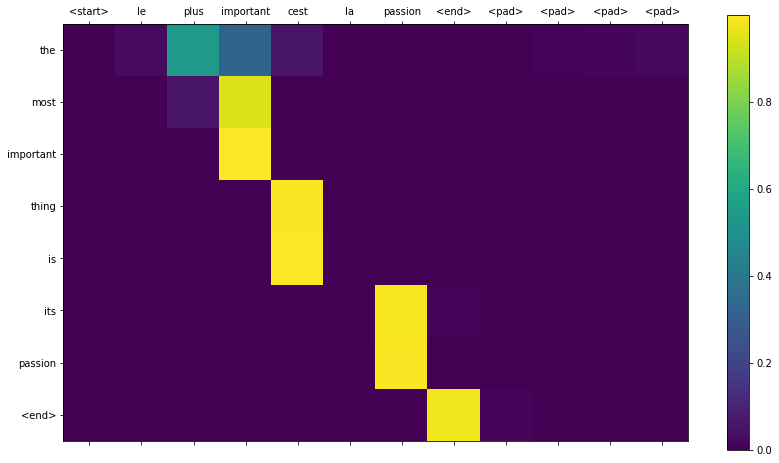

let me tell you a secret


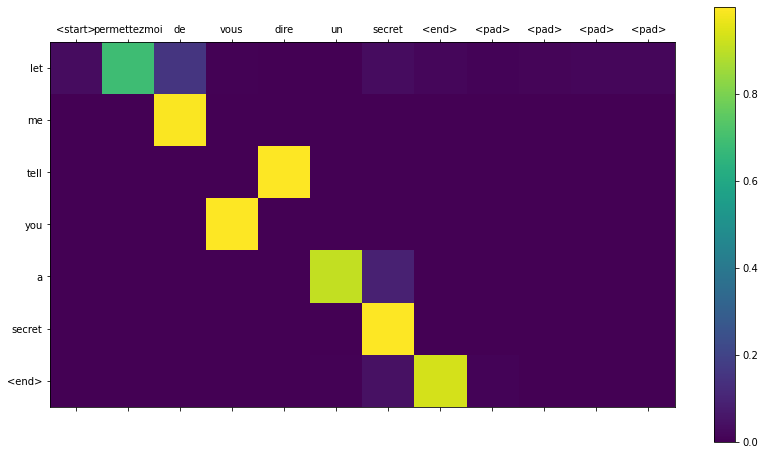

there is a problem with community meetings


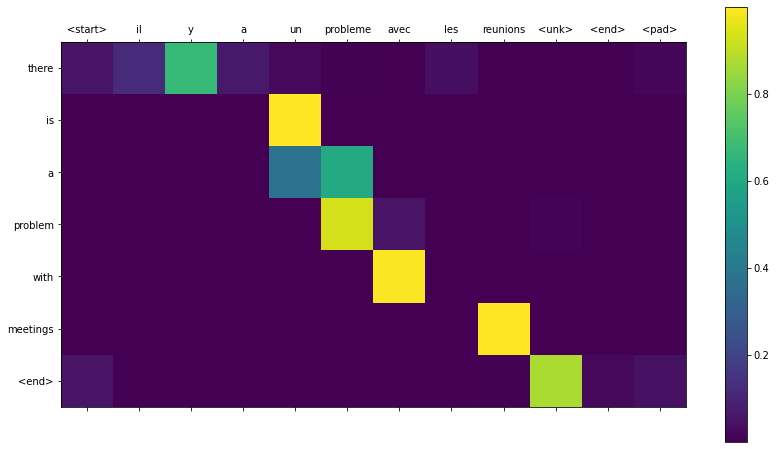

In [ ]:
example_ids = [12, 14, 15]
for idx in example_ids:
  sent = val_data[idx]
  print(val_target[idx])
  with torch.no_grad():
    # inp = clean_line(sent)
    # prin
    sent = tokenize_sent(sent)
    sent = pad_seq(10, [sent], 2)
    # print(sent)
    sent = torch.tensor(sent[0], device=device)
    inp = " ".join(word for word in [fr_idx2word[token] for token in sent.cpu().numpy()])
    sent = torch.tensor(sent, device=device)
    res, atts = predictv2(encoderv2, decoderv2, sent)
    # print(res)
  # atts[0][0][0].shape
  out = " ".join(word for word in [eng_idx2word[token] for token in res])
  make_atts = []
  for vec in atts:
    make_atts.append(vec[0][0])
  make_atts = np.array(make_atts)
  fig = plt.figure(figsize=(14,8))
  ax = fig.add_subplot(111)
  cax = ax.matshow(make_atts)
  fig.colorbar(cax)
  ax.set_xticklabels([""]+inp.split())
  ax.set_yticklabels(out.split())
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()


In [ ]:
out = " ".join(word for word in [eng_idx2word[token] for token in res])
out

'<start> the most important thing is its passion <end>'

In [ ]:
# atts

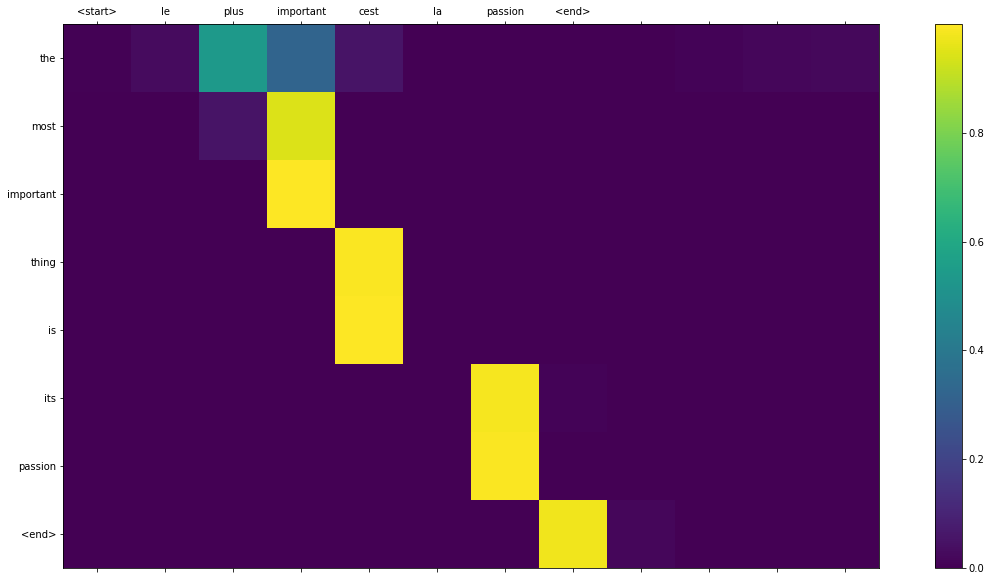

In [ ]:
# atts[0][0][0].shape
make_atts = []
for vec in atts:
  make_atts.append(vec[0][0])
make_atts = np.array(make_atts)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cax = ax.matshow(make_atts)
fig.colorbar(cax)
ax.set_xticklabels([""]+inp.split())
ax.set_yticklabels(out.split())
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()
